In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input, GlobalMaxPooling1D, LayerNormalization, Conv1D, Concatenate, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from pyvi import ViTokenizer
from pyvi import ViUtils
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
data = pd.read_excel('datatrain.xlsx')
data.head()


,id,thank_count,customer_id,rating,created_at,content,title
0,NaN,0,29007408,2,1680622562,Máy yếu . Giật lag .,Tiêu cực
1,NaN,0,5229895,4,1676870198,Không bật lên được,Tiêu cực
2,NaN,1,16968933,5,1658741347,Đừng nên mua chỉ phí tiền,Tiêu cực
3,NaN,0,10498768,4,1675745522,"Hệ điều hành phiên bản này không ổn định, được...",Tiêu cực
4,NaN,0,14122,5,1659937466,Dùng được 2 ngày thì sạc không vào,Tiêu cực


In [3]:
sentiment_data = pd.DataFrame({'input' : data['content'], 'label' : data['title']})
sentiment_data = sentiment_data.dropna()
sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.head()


,input,label
0,Máy yếu . Giật lag .,Tiêu cực
1,Không bật lên được,Tiêu cực
2,Đừng nên mua chỉ phí tiền,Tiêu cực
3,"Hệ điều hành phiên bản này không ổn định, được...",Tiêu cực
4,Dùng được 2 ngày thì sạc không vào,Tiêu cực


In [5]:
input_data = sentiment_data['input'].values
input_label = sentiment_data['label'].values
label_dict = {'Tiêu cực' : 0, 'Trung lập' : 1, 'Tích cực' : 2}
input_pre = []
label_with_accent = []
for idx, dt in enumerate(input_data):
	input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(dt))
	input_text_pre = " ".join(input_text_pre)
	input_text_pre_no_accent = str(ViUtils.remove_accents(input_text_pre).decode("utf-8"))
	input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
	input_text_pre_no_accent = ViTokenizer.tokenize(input_text_pre_no_accent)
	input_pre.append(input_text_pre_accent)
	input_pre.append(input_text_pre_no_accent)
	label_with_accent.append(input_label[idx])
	label_with_accent.append(input_label[idx])


input data.shape: (10036, 820)
data_vocab_size:  6235
training sample:  8028
test sample:  2008


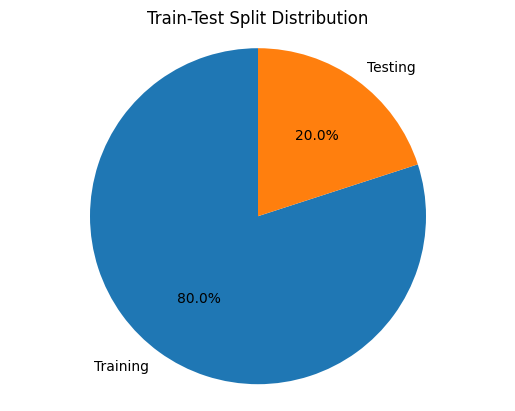

In [6]:
label_idx = [label_dict[i] for i in label_with_accent]
label_tf = tf.keras.utils.to_categorical(label_idx, num_classes=3)

tokenizer_data = Tokenizer(oov_token='<OOV>', filters = '', split = ' ')
tokenizer_data .fit_on_texts(input_pre)

tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)
vec_data = pad_sequences(tokenizer_data_text, padding = 'post', maxlen = 820)

pickle.dump(tokenizer_data, open("tokenizer_data.pkl", "wb"))
print("input data.shape:", vec_data.shape)
data_vocab_size = len (tokenizer_data.word_index)+1
print("data_vocab_size: ", data_vocab_size)

x_train, x_test, y_train, y_test = train_test_split( vec_data, label_tf, test_size = 0.2, random_state = 42)
print("training sample: ", len(x_train))
print("test sample: ", len(x_test))
import matplotlib.pyplot as plt

train_size = len(x_train)
test_size = len(x_test)
sizes = [train_size, test_size]
labels = ['Training', 'Testing']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title("Train-Test Split Distribution")
plt.show()


In [7]:

def generate_model():
    dropout_threshold = 0.4
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 820
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length,
                        embeddings_initializer="GlorotNormal")(input_layer)

    lstm_feature = Bidirectional(LSTM(units=16, dropout=dropout_threshold, return_sequences=True,
                        kernel_initializer=initializer))(feature)
    lstm_feature = MaxPooling1D()(lstm_feature)
    lstm_feature = LayerNormalization()(lstm_feature)

    combine_feature = GlobalMaxPooling1D()(lstm_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    return model

model = generate_model()
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 820)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 820, 32)        │       199,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 820, 32)        │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 410, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 410, 32)        │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 90)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         6,370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            93 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,433 (861.07 KB)

 Trainable params: 220,433 (861.07 KB)

 Non-trainable params: 0 (0.00 B)

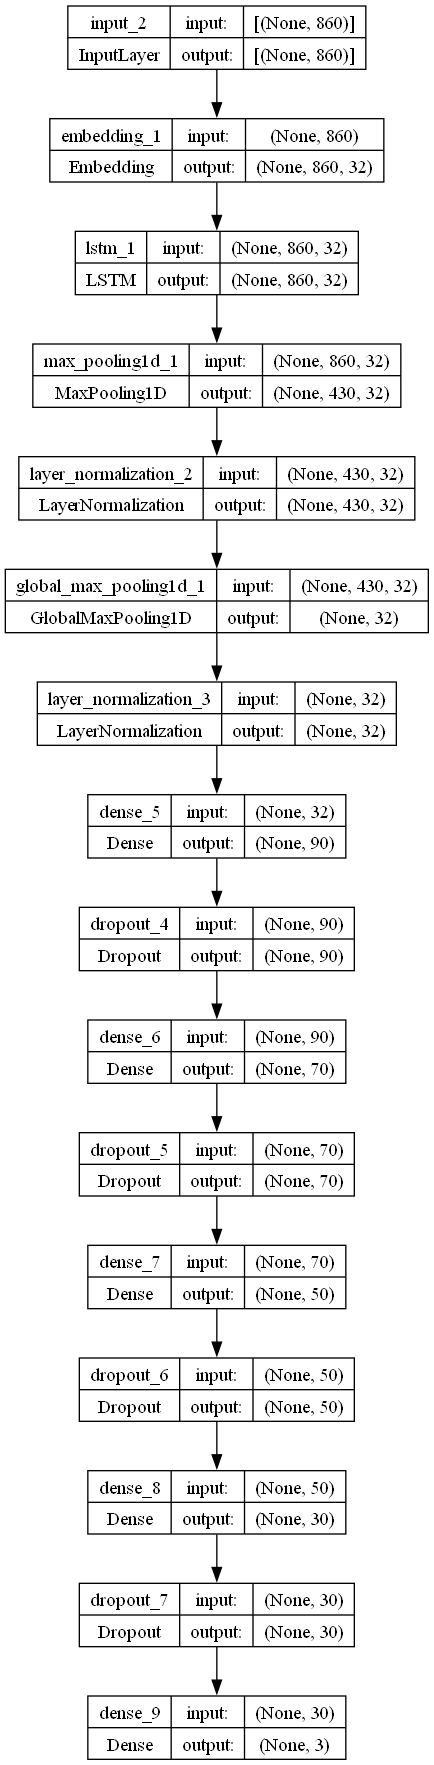

In [18]:
import pydot 
dot_img_file = 'model_visualize_2.png'
tf.keras.utils.plot_model(model, to_file = dot_img_file, show_shapes = True)

In [ ]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_lstm.keras', monitor = 'val_loss')
history = model.fit( x = x_train, y = y_train, epochs = 1, batch_size = 128, 
                    callbacks = [callback_model])


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 688ms/step - accuracy: 0.4028 - loss: 1.0790
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 674ms/step - accuracy: 0.4945 - loss: 0.9192
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 805ms/step - accuracy: 0.7291 - loss: 0.6476
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 59s 934ms/step - accuracy: 0.8090 - loss: 0.5003
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 977ms/step - accuracy: 0.8390 - loss: 0.4158
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 60s 955ms/step - accuracy: 0.8663 - loss: 0.3559
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8847 - loss: 0.3273
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 978ms/step - accuracy: 0.8887 - loss: 0.3089
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 63s 993ms/step - accuracy: 0.9025 - loss: 0.2741
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 977ms/step - accuracy: 0.9096 - loss: 0.2636
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 984ms/step - accuracy: 0.9123 - loss: 0.2494
Epoch 12/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 62s 9

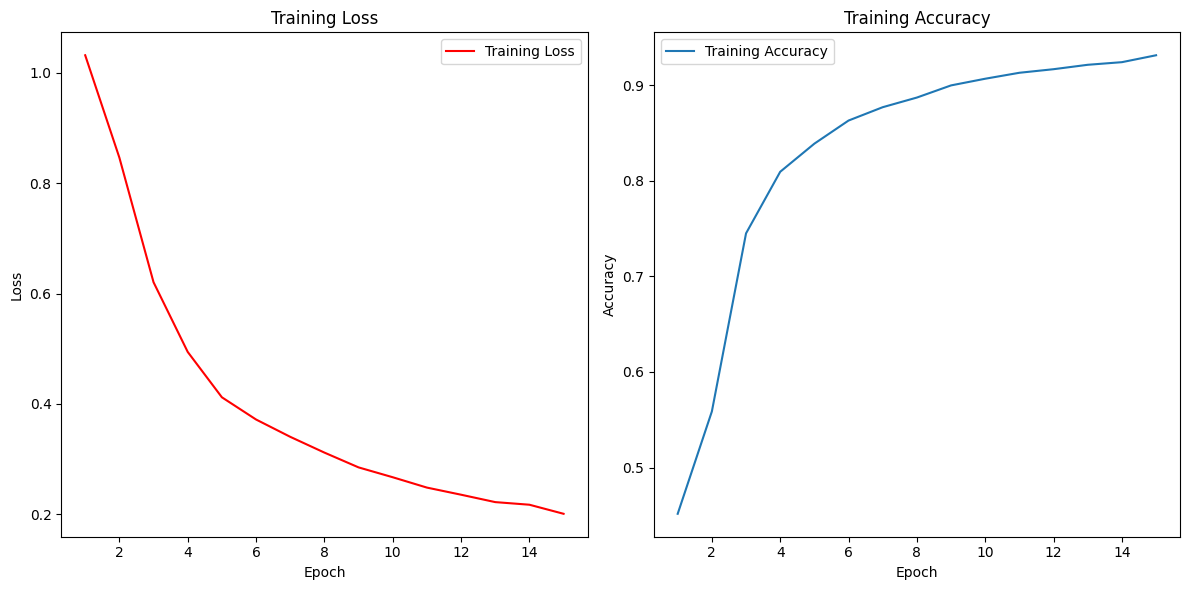

In [14]:
import matplotlib.pyplot as plt

# Lấy thông tin từ đối tượng history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
epochs = range(1, len(train_loss) + 1)

# Vẽ biểu đồ Loss và Accuracy trên cùng một biểu đồ
plt.figure(figsize=(12, 6))

# Biểu đồ Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color = 'red')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [71]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_lstm.keras', monitor = 'val_loss')
history = model.fit( x = x_train, y = y_train, epochs = 1, batch_size = 128, 
                    callbacks = [callback_model])


63/63 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9557 - loss: 0.1317


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.7989 - loss: 0.9419
Test Loss: 0.9068390727043152
Test Accuracy: 0.8027888536453247
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


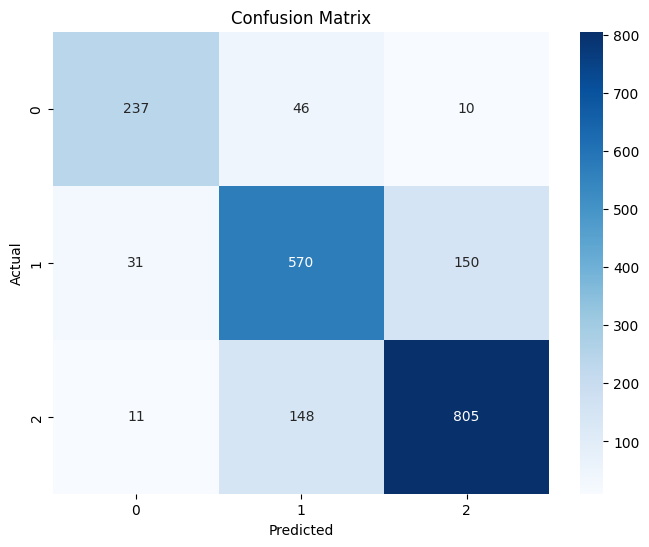

              precision    recall  f1-score   support

    Tiêu cực       0.85      0.81      0.83       293
   Trung lập       0.75      0.76      0.75       751
    Tích cực       0.83      0.84      0.83       964

    accuracy                           0.80      2008
   macro avg       0.81      0.80      0.81      2008
weighted avg       0.80      0.80      0.80      2008



In [72]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Load the best weights
model.load_weights('model_lstm.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict the test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print a classification report
report = classification_report(y_true, y_pred, target_names=label_dict.keys())
print(report)


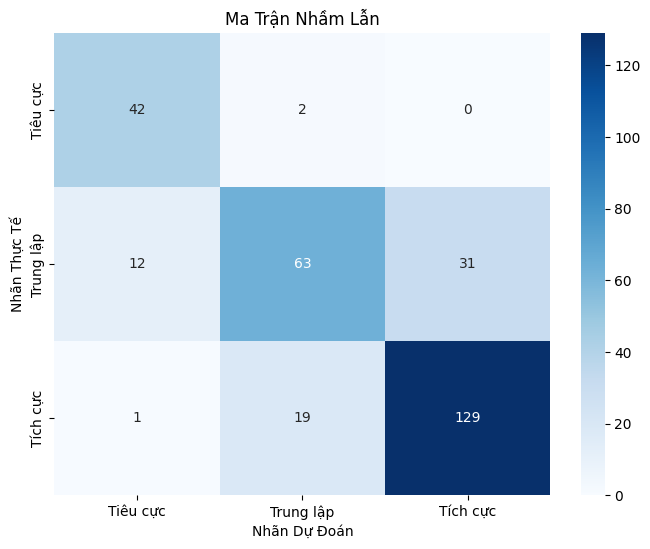

Báo cáo phân loại:
              precision    recall  f1-score   support

    Tiêu cực       0.76      0.95      0.85        44
   Trung lập       0.75      0.59      0.66       106
    Tích cực       0.81      0.87      0.83       149

    accuracy                           0.78       299
   macro avg       0.77      0.80      0.78       299
weighted avg       0.78      0.78      0.78       299



In [10]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from pyvi import ViTokenizer

# Load model và tokenizer
my_model = load_model('model_lstm.keras')

with open("tokenizer_data.pkl", "rb") as input_file:
    my_tokenizer = pickle.load(input_file)

# Hàm xử lý đầu vào
def preprocess_raw_input(raw_input, tokenizer):
    input_text_pre = list(tf.keras.preprocessing.text.text_to_word_sequence(raw_input))
    input_text_pre = " ".join(input_text_pre)
    input_text_pre_accent = ViTokenizer.tokenize(input_text_pre)
    tokenizer_data_text = tokenizer.texts_to_sequences([input_text_pre_accent])
    vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen=820)
    return vec_data

# Hàm inference
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()
    conf = float(output.max())
    label_dict = {0: 'Tiêu cực', 1: 'Trung lập', 2: 'Tích cực'}
    return label_dict[result], conf

# Hàm dự đoán
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)
    result, _ = inference_model(input_model, model)
    return result

# Đọc file đầu vào
input_file_path = 'dulieumoi.xlsx'  # Đường dẫn file đầu vào
df = pd.read_excel(input_file_path)

# Kiểm tra dữ liệu đầu vào
if 'tweets' not in df.columns or 'camxuc' not in df.columns:
    raise ValueError("Tệp đầu vào cần có cột 'tweets' và 'camxuc'.")

# Áp dụng dự đoán
df['bilstm'] = df['tweets'].apply(lambda x: prediction(x, my_tokenizer, my_model))



# Tính toán ma trận nhầm lẫn
y_true = df['camxuc']
y_pred = df['bilstm']

confusion = confusion_matrix(y_true, y_pred, labels=['Tiêu cực', 'Trung lập', 'Tích cực'])

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'],
            yticklabels=['Tiêu cực', 'Trung lập', 'Tích cực'])
plt.xlabel('Nhãn Dự Đoán')
plt.ylabel('Nhãn Thực Tế')
plt.title('Ma Trận Nhầm Lẫn')
plt.show()

# Báo cáo chi tiết
report = classification_report(y_true, y_pred, output_dict=False)
print("Báo cáo phân loại:")
print(report)


In [6]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [7]:
def generate_model(dropout_threshold=0.4, learning_rate=0.01, lstm_units=32):
    input_dim = data_vocab_size
    output_dim = 32
    input_length = 820
    initializer = tf.keras.initializers.GlorotNormal()

    input_layer = Input(shape=(input_length,))
    feature = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length,
                        embeddings_initializer="GlorotNormal")(input_layer)

    lstm_feature = Bidirectional(LSTM(units=lstm_units, dropout=dropout_threshold, return_sequences=True,
                        kernel_initializer=initializer))(feature)
    lstm_feature = MaxPooling1D()(lstm_feature)
    lstm_feature = LayerNormalization()(lstm_feature)

    combine_feature = GlobalMaxPooling1D()(lstm_feature)
    combine_feature = LayerNormalization()(combine_feature)

    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    model = tf.keras.Model(inputs=input_layer, outputs=classifier)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:

# Wrap model into KerasClassifier
model = KerasClassifier(build_fn=generate_model, dropout_threshold=0.4,
    learning_rate=0.001, lstm_units = 32, epochs=10, batch_size=64, verbose=1)

# Định nghĩa không gian siêu tham số
param_grid = {
    'dropout_threshold': [0.4],  # Thử nghiệm với các giá trị khác nhau
    'learning_rate': [0.001, 0.01],  # Các giá trị learning rate khác nhau
    'lstm_units': [16, 32],  # Số đơn vị trong LSTM
    'batch_size': [64, 128,256],
    'epochs': [10, 15, 20]
}

# Khởi tạo GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)



In [9]:
# Thực hiện Grid Search
grid_result = grid.fit(x_train, y_train)

# In kết quả của từng tổ hợp siêu tham số
print("Từng bộ tham số và kết quả:")
for mean, std, params in zip(grid_result.cv_results_['mean_test_score'], 
                             grid_result.cv_results_['std_test_score'], 
                             grid_result.cv_results_['params']):
    print(f"Độ chính xác trung bình: {mean:.4f} (std: {std:.4f}) với tham số: {params}")

# In kết quả tốt nhất
print("\nKết quả tốt nhất:")
print("Độ chính xác: %f sử dụng bộ tham số %s" % (grid_result.best_score_, grid_result.best_params_))

c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\LG\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 495ms/step - accuracy: 0.4237 - loss: 1.0449
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 607ms/step - accuracy: 0.5215 - loss: 0.9558
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 701ms/step - accuracy: 0.7039 - loss: 0.6817
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 774ms/step - accuracy: 0.8025 - loss: 0.4913
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 49s 773ms/step - accuracy: 0.8289 - loss: 0.4349
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 788ms/step - accuracy: 0.8600 - loss: 0.3779
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.8798 - loss: 0.3390
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 799ms/step - accuracy: 0.8865 - loss: 0.3113
Epoch 9/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 786ms/step - accuracy: 0.8968 - loss: 0.2711
Epoch 10/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 815ms/step - accuracy: 0.9024 - loss: 0.2793
Epoch 11/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 795ms/step - accuracy: 0.9067 - loss: 0.2566
Epoch 12/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 50

In [10]:
from tabulate import tabulate

results = {
    "Mean Accuracy": grid_result.cv_results_['mean_test_score'],
    "Std Dev": grid_result.cv_results_['std_test_score'],
    "Parameters": grid_result.cv_results_['params']
}

results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print("Bảng kết quả các tổ hợp siêu tham số:")
print(tabulate(results_df, headers="keys", tablefmt="grid"))

# Hiển thị kết quả tốt nhất
print("\nKết quả tốt nhất:")
print(f"Độ chính xác: {grid_result.best_score_:.4f} sử dụng bộ tham số {grid_result.best_params_}")

Bảng kết quả các tổ hợp siêu tham số:
+----+-----------------+-------------+-------------------------------------------------------------------------------------------------------+
|    |   Mean Accuracy |     Std Dev | Parameters                                                                                            |
+====+=================+=============+=======================================================================================================+
|  0 |        0.789487 | 0.00366565  | {'batch_size': 64, 'dropout_threshold': 0.4, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 16}  |
+----+-----------------+-------------+-------------------------------------------------------------------------------------------------------+
|  1 |        0.793473 | 0.00796431  | {'batch_size': 64, 'dropout_threshold': 0.4, 'epochs': 10, 'learning_rate': 0.001, 'lstm_units': 32}  |
+----+-----------------+-------------+------------------------------------------------------------------

In [11]:
import pandas as pd
from tabulate import tabulate

# Thực hiện Grid Search

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame({
    "Mean Accuracy": grid_result.cv_results_['mean_test_score'],
    "Std Dev": grid_result.cv_results_['std_test_score'],
    "Parameters": grid_result.cv_results_['params']
})

# Chuyển từ cột Parameters sang từng cột riêng cho mỗi siêu tham số
params_df = results_df["Parameters"].apply(pd.Series)
results_df = pd.concat([results_df.drop("Parameters", axis=1), params_df], axis=1)

# Nhóm theo một siêu tham số, ví dụ là 'batch_size'
grouped_df = results_df.groupby("learning_rate", )

# In bảng có nhóm
print("Bảng kết quả các tổ hợp siêu tham số theo batch_size:")
for learning_rate, group in grouped_df:
    print(f"\nlearning_rate = {learning_rate}")
    print(tabulate(group.drop(columns="learning_rate"), headers="keys", tablefmt="grid"))

# Hiển thị kết quả tốt nhất
print("\nKết quả tốt nhất:")
print(f"Độ chính xác: {grid_result.best_score_:.4f} sử dụng bộ tham số {grid_result.best_params_}")


Bảng kết quả các tổ hợp siêu tham số theo batch_size:

learning_rate = 0.001
+----+-----------------+-------------+--------------+---------------------+----------+--------------+
|    |   Mean Accuracy |     Std Dev |   batch_size |   dropout_threshold |   epochs |   lstm_units |
+====+=================+=============+==============+=====================+==========+==============+
|  0 |        0.789487 | 0.00366565  |           64 |                 0.4 |       10 |           16 |
+----+-----------------+-------------+--------------+---------------------+----------+--------------+
|  1 |        0.793473 | 0.00796431  |           64 |                 0.4 |       10 |           32 |
+----+-----------------+-------------+--------------+---------------------+----------+--------------+
|  4 |        0.789985 | 0.00169883  |           64 |                 0.4 |       15 |           16 |
+----+-----------------+-------------+--------------+---------------------+----------+--------------+
|  5 

C:\Users\LG\AppData\Local\Temp\ipykernel_16536\1406500997.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  params_df = results_df["Parameters"].apply(pd.Series)


In [12]:
import pandas as pd
from tabulate import tabulate

# Thực hiện Grid Search

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame({
    "Mean Accuracy": grid_result.cv_results_['mean_test_score'],
    "Std Dev": grid_result.cv_results_['std_test_score'],
    "Parameters": grid_result.cv_results_['params']
})

# Chuyển từ cột Parameters sang từng cột riêng cho mỗi siêu tham số
params_df = results_df["Parameters"].apply(pd.Series)
results_df = pd.concat([results_df.drop("Parameters", axis=1), params_df], axis=1)

# Nhóm theo một siêu tham số, ví dụ là 'batch_size'
grouped_df = results_df.groupby("batch_size", )

# In bảng có nhóm
print("Bảng kết quả các tổ hợp siêu tham số theo batch_size:")
for batch_size, group in grouped_df:
    print(f"\nbatch_size = {batch_size}")
    print(tabulate(group.drop(columns="batch_size"), headers="keys", tablefmt="grid"))

# Hiển thị kết quả tốt nhất
print("\nKết quả tốt nhất:")
print(f"Độ chính xác: {grid_result.best_score_:.4f} sử dụng bộ tham số {grid_result.best_params_}")


Bảng kết quả các tổ hợp siêu tham số theo batch_size:

batch_size = 64.0
+----+-----------------+------------+---------------------+----------+-----------------+--------------+
|    |   Mean Accuracy |    Std Dev |   dropout_threshold |   epochs |   learning_rate |   lstm_units |
+====+=================+============+=====================+==========+=================+==============+
|  0 |        0.789487 | 0.00366565 |                 0.4 |       10 |           0.001 |           16 |
+----+-----------------+------------+---------------------+----------+-----------------+--------------+
|  1 |        0.793473 | 0.00796431 |                 0.4 |       10 |           0.001 |           32 |
+----+-----------------+------------+---------------------+----------+-----------------+--------------+
|  2 |        0.785376 | 0.00486598 |                 0.4 |       10 |           0.01  |           16 |
+----+-----------------+------------+---------------------+----------+-----------------+-------

C:\Users\LG\AppData\Local\Temp\ipykernel_16536\4253514958.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  params_df = results_df["Parameters"].apply(pd.Series)
